In [40]:
# prepare data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10("data",
                              train=True,
                              transform=transform,
                              download=True)

test_data = datasets.CIFAR10("data",
                             train=False,
                             transform=transform,
                             download=True)

# Load data
batch_size = 32
train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=5)

test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=5)


print(len(train_loader))
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
1563


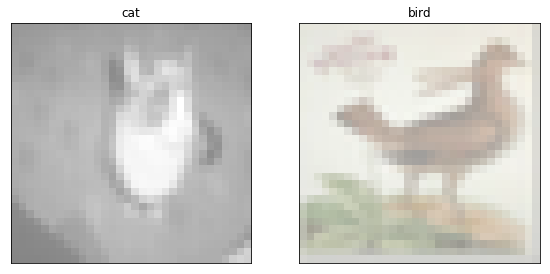

In [57]:
# visualize data
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

data_iter = iter(train_loader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    # unnormolaize first
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0)) #transpose
    ax.imshow(img, cmap='gray')
    item = labels[idx].item()
    ax.set_title(classes[item])

In [0]:
def show(img):
  fig = plt.figure(figsize=(25, 5))

  ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
  # unnormolaize first
  img = images[idx] / 2 + 0.5
  npimg = img.numpy()
  img = np.transpose(npimg, (1, 2, 0)) #transpose
  ax.imshow(img, cmap='gray')

In [89]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    #Linear layer
    self.linear1 = nn.Linear(3072, 786)
    self.linear2 = nn.Linear(786, 512)
    self.linear3 = nn.Linear(512, 256)
    self.linear4 = nn.Linear(256, 128)
    self.linear5 = nn.Linear(128, 64)
    self.linear6 = nn.Linear(64, 10)
    #dropout
    self.dropout = nn.Dropout(0.2)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1) #flaten the tensor
    out1 = self.dropout(F.relu(self.linear1(x)))
    out2 = self.dropout(F.relu(self.linear2(out1)))
    out3 = self.dropout(F.relu(self.linear3(out2)))
    out4 = self.dropout(F.relu(self.linear4(out3)))
    out5 = self.dropout(F.relu(self.linear5(out4)))
    
    
    # last layer
    out6 = self.linear6(out5)
    
    out7 = F.softmax(out1)
    
    return out6
  
  
model = Model()
model

Model(
  (linear1): Linear(in_features=3072, out_features=786, bias=True)
  (linear2): Linear(in_features=786, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
  (linear5): Linear(in_features=128, out_features=64, bias=True)
  (linear6): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [111]:
import torch.optim as optim
import torch

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (linear1): Linear(in_features=3072, out_features=786, bias=True)
  (linear2): Linear(in_features=786, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
  (linear5): Linear(in_features=128, out_features=64, bias=True)
  (linear6): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [112]:
# train
n_epoch = 30
# track loss
train_loss_data, valid_loss_data = [], []
#minimum loss
min_loss = np.Inf

for epoch in range(n_epoch):
  #train and valid loss
  train_loss = 0
  valid_loss = 0
  
  #############
  # Train     #
  ############
  model.train()
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    
    #clear gradient
    optimizer.zero_grad()
    
    #forward pass
    output = model(data)
    #loss
    loss = criterion(output, target)
    #backward pass
    loss.backward()
    
    #setp up critrion
    optimizer.step()
    
    #calculate loss
    train_loss += loss.item()
    
  
  ##############
  # Evaluation #
  ##############
  model.eval()
  for data, target in test_loader:
    # move to gpu
    data, target = data.to(device), target.to(device)
    #forward pass
    output = model(data)
    #loss
    loss = criterion(output, target)
    #calculate loss
    valid_loss += loss.item()
    
  
  # calculate average loss over an epoch
  train_loss = train_loss / len(train_loader)
  valid_loss = valid_loss / len(test_loader)
  
  #append the data
  train_loss_data.append(train_loss)
  valid_loss_data.append(valid_loss)
  
  # print training/validation statistics
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, train_loss,valid_loss))
  
  # save model if validation loss has decreased
  if valid_loss <= min_loss:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    min_loss,
    valid_loss))
    torch.save(model.state_dict(), 'model.pt')
    min_loss = valid_loss
  

Epoch: 1 	Training Loss: 1.561679 	Validation Loss: 1.485522
Validation loss decreased (inf --> 1.485522).  Saving model ...
Epoch: 2 	Training Loss: 1.539169 	Validation Loss: 1.489961
Epoch: 3 	Training Loss: 1.525302 	Validation Loss: 1.459332
Validation loss decreased (1.485522 --> 1.459332).  Saving model ...
Epoch: 4 	Training Loss: 1.499494 	Validation Loss: 1.435023
Validation loss decreased (1.459332 --> 1.435023).  Saving model ...
Epoch: 5 	Training Loss: 1.482925 	Validation Loss: 1.466523
Epoch: 6 	Training Loss: 1.467555 	Validation Loss: 1.455384
Epoch: 7 	Training Loss: 1.459163 	Validation Loss: 1.410771
Validation loss decreased (1.435023 --> 1.410771).  Saving model ...
Epoch: 8 	Training Loss: 1.439647 	Validation Loss: 1.402659
Validation loss decreased (1.410771 --> 1.402659).  Saving model ...
Epoch: 9 	Training Loss: 1.426219 	Validation Loss: 1.401739
Validation loss decreased (1.402659 --> 1.401739).  Saving model ...
Epoch: 10 	Training Loss: 1.411136 	Valida

In [118]:
# load the saved model
model.load_state_dict(torch.load('model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

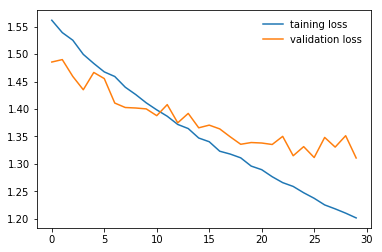

In [119]:
# check for overfitting
plt.plot(train_loss_data, label = "taining loss")
plt.plot(valid_loss_data, label = "validation loss")
plt.legend(frameon = False)

In [127]:
# calculate loss
test_loss = 0.0
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

model.to(device)
model.eval() # prepare for evaluation
for data, target in test_loader:
  # move to gpu
  data, target = data.to(device), target.to(device)
  #forward pass
  output = model(data)
  #loss
  loss = criterion(output, target)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  correct = np.squeeze(pred.eq(target.data.view_as(pred)))
  for i in range(16):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
          

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
              
              

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of     0: 53% (166/313)
Test Accuracy of     1: 51% (162/313)
Test Accuracy of     2: 55% (173/313)
Test Accuracy of     3: 52% (497/939)
Test Accuracy of     4: 53% (505/939)
Test Accuracy of     5: 53% (167/313)
Test Accuracy of     6: 52% (490/939)
Test Accuracy of     7: 52% (326/626)
Test Accuracy of  ship: N/A (no training examples)
Test Accuracy of     9: 50% (157/313)

Test Accuracy (Overall): 52% (2643/5008)


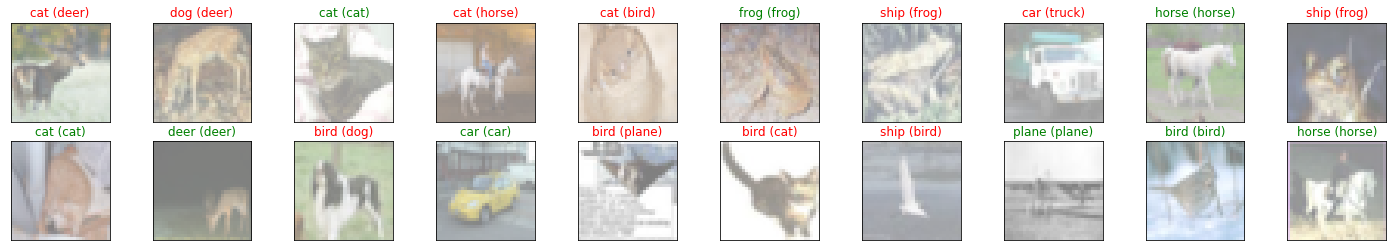

In [115]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Move to cpu
model.cpu()
  
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    ax.imshow(img, cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx].item()], classes[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx] else "red"))